In [1]:
import pandas as pd
import re, string
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sim_df = pd.read_csv('data/similarity.csv', index_col='anime_id')
sim_df.columns = sim_df.columns.astype(sim_df.index.dtype)
sim_df

,5114,9253,820,4181,2904,199,1575,44,1,30276,...,3981,9851,11825,3635,5402,18483,14207,18197,10368,26081
anime_id,,,,,,,,,,,,,,,,,,,,,
5114,0.000000,0.210526,0.084211,0.280702,0.315789,0.093567,0.275304,0.064777,0.325359,0.238596,...,0.000000,0.038278,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9253,0.210526,0.000000,0.070175,0.210526,0.257310,0.000000,0.257310,0.000000,0.263158,0.252632,...,0.000000,0.000000,0.000000,0.084211,0.000000,0.105263,0.000000,0.000000,0.000000,0.000000
820,0.084211,0.070175,0.000000,0.042105,0.140351,0.060150,0.084211,0.248804,0.157895,0.035088,...,0.210526,0.000000,0.210526,0.350877,0.210526,0.280702,0.210526,0.210526,0.210526,0.000000
4181,0.280702,0.210526,0.042105,0.000000,0.242915,0.105263,0.210526,0.070175,0.245614,0.240602,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2904,0.315789,0.257310,0.140351,0.242915,0.000000,0.084211,0.842105,0.064777,0.325359,0.350877,...,0.052632,0.084211,0.000000,0.042105,0.000000,0.079172,0.000000,0.000000,0.052632,0.046784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18483,0.000000,0.105263,0.280702,0.000000,0.079172,0.035088,0.081871,0.210526,0.052632,0.042105,...,0.392982,0.070175,0.294737,0.421053,0.350877,0.000000,0.350877,0.294737,0.392982,0.178628
14207,0.000000,0.000000,0.210526,0.000000,0.000000,0.000000,0.000000,0.210526,0.000000,0.000000,...,0.421053,0.084211,0.315789,0.315789,0.421053,0.350877,0.000000,0.315789,0.421053,0.210526
18197,0.000000,0.000000,0.210526,0.000000,0.000000,0.000000,0.000000,0.210526,0.046784,0.084211,...,0.315789,0.140351,0.378947,0.280702,0.315789,0.294737,0.315789,0.000000,0.315789,0.105263


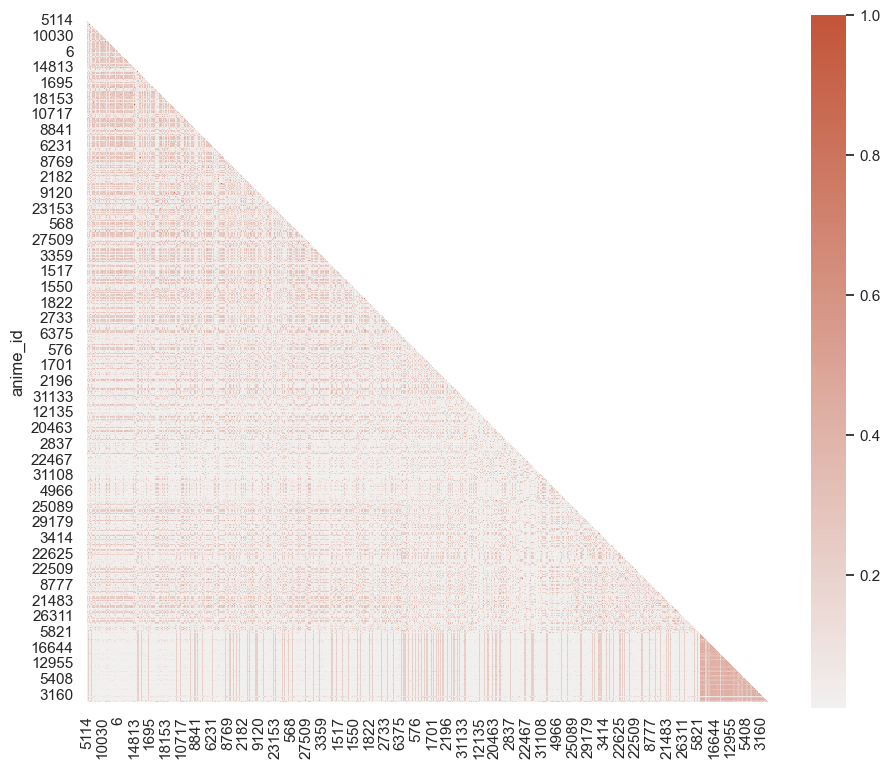

In [3]:
# Configure seaborn to set the plot style to 'white'
sns.set_theme(style="white")

# Create a mask for the upper triangle of the similarity matrix
mask = np.triu(np.ones_like(sim_df, dtype=bool))

# Create a new figure and axis for the heatmap
_, ax = plt.subplots(figsize=(11, 9))

# Create a diverging color palette for the heatmap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Plot a similarity heat map using seaborn's heatmap function
sns.heatmap(sim_df, mask=mask, cmap=cmap, vmin=0.01, vmax=1, center=0,
            square=True);

In [2]:
rating_df = pd.read_csv('data/rating_shortened.csv')
rating_df = rating_df[rating_df.rating!=-1]
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1741995 entries, 12 to 2084434
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 53.2 MB


### generate and save predictions

In [5]:
all_animes=set(sim_df.index)

In [43]:
def generate_predictions(user_identifier, threshold=0.50):
    user_watched_animes = set(rating_df[rating_df.user_id==user_identifier].anime_id)
    user_unwatched_animes = all_animes-user_watched_animes
    preds={}
    for watched_anime in user_watched_animes:
        for unwatched_anime in user_unwatched_animes:
            simval = sim_df.at[watched_anime, unwatched_anime]
            if simval>=threshold:
                if (unwatched_anime not in preds) or (simval > preds[unwatched_anime]):
                    preds[unwatched_anime]=simval
    if len(preds)==0:
        return None
    preds=pd.DataFrame([[key, val] for (key,val) in preds.items()])
    preds.columns=['anime_id', 'value']
    preds['user_id']=np.tile(user_identifier, len(preds))
    preds=preds[['user_id', 'anime_id', 'value']].sort_values(by='value', ascending=False, ignore_index=True)
    return preds

In [47]:
all_preds=[]
for user_identifier in rating_df.user_id.unique():
    pred = generate_predictions(user_identifier)
    if pred is not None:
        all_preds.append(pred)

In [48]:
similarity_predictions_df=pd.concat(all_preds, ignore_index=True)

In [49]:
similarity_predictions_df

,user_id,anime_id,value
0,1,21881,0.877193
1,1,30300,0.511278
2,2,30230,0.607519
3,2,20473,0.547368
4,2,17669,0.533333
...,...,...,...
800690,73515,24405,0.508772
800691,73515,21483,0.505263
800692,73515,20077,0.505263
800693,73515,28805,0.505263


In [50]:
similarity_predictions_df.to_csv("data/similarity_predictions.csv", index=False)

### evaluating results

In [4]:
similarity_predictions_df=pd.read_csv("data/similarity_predictions.csv")

In [6]:
similarity_predictions_df.anime_id.nunique()

238

In [8]:
similarity_predictions_df.shape[0]/similarity_predictions_df.user_id.nunique()

12.913602348235598

In [5]:
anime_df = pd.read_csv('data/anime_shortened.csv')
anime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  1000 non-null   int64  
 1   name      1000 non-null   object 
 2   genre     1000 non-null   object 
 3   type      1000 non-null   object 
 4   episodes  1000 non-null   int64  
 5   rating    1000 non-null   float64
 6   members   1000 non-null   int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 54.8+ KB


In [12]:
1 - similarity_predictions_df.user_id.nunique()/rating_df.user_id.nunique()

0.07420790157374502

In [13]:
top_10_by_number_of_recommendations=similarity_predictions_df.groupby(by='anime_id').value.count().sort_values(ascending=False).iloc[:10].to_frame()
top_10_by_number_of_recommendations.columns=['number_of_recommendations']
top_10_by_number_of_recommendations = pd.merge(left=top_10_by_number_of_recommendations, 
                                               left_on='anime_id',
                                               right=anime_df, 
                                               right_on='anime_id',
                                               how='left')
top_10_by_number_of_recommendations

,anime_id,number_of_recommendations,name,genre,type,episodes,rating,members
0,509,31310,I My Me! Strawberry Eggs,"Comedy, Drama, Romance, School, Slice of Life",TV,13,6.93,25043
1,22777,28421,Dragon Ball Kai (2014),"Action, Adventure, Comedy, Fantasy, Martial Ar...",TV,61,8.01,42666
2,11235,26055,Amagami SS+ Plus,"Comedy, Romance, School, Slice of Life",TV,13,7.61,73813
3,21405,24114,Bokura wa Minna Kawaisou,"Comedy, Romance, School, Slice of Life",TV,12,7.90,159793
4,13759,23578,Sakurasou no Pet na Kanojo,"Comedy, Drama, Romance, School, Slice of Life",TV,24,8.40,380375
5,18397,22581,Shingeki no Kyojin OVA,"Action, Drama, Fantasy, Shounen, Super Power",OVA,3,7.88,121063
6,14741,20669,Chuunibyou demo Koi ga Shitai!,"Comedy, Drama, Romance, School, Slice of Life",TV,12,7.95,394399
7,14227,17437,Tonari no Kaibutsu-kun,"Comedy, Romance, School, Shoujo, Slice of Life",TV,13,7.77,349836
8,11739,15726,Kimi to Boku. 2,"Comedy, Drama, Romance, School, Shounen, Slice...",TV,13,8.11,44564
9,10460,15081,Kimi to Boku.,"Comedy, Drama, Romance, School, Shounen, Slice...",TV,13,7.85,86196


In [14]:
top_10_by_number_of_recommendations.drop(columns=['anime_id', 'genre', 'type', 'episodes', 'members'])

,number_of_recommendations,name,rating
0,31310,I My Me! Strawberry Eggs,6.93
1,28421,Dragon Ball Kai (2014),8.01
2,26055,Amagami SS+ Plus,7.61
3,24114,Bokura wa Minna Kawaisou,7.90
4,23578,Sakurasou no Pet na Kanojo,8.40
5,22581,Shingeki no Kyojin OVA,7.88
6,20669,Chuunibyou demo Koi ga Shitai!,7.95
7,17437,Tonari no Kaibutsu-kun,7.77
8,15726,Kimi to Boku. 2,8.11
9,15081,Kimi to Boku.,7.85


In [15]:
score = np.dot(top_10_by_number_of_recommendations.number_of_recommendations, 
               top_10_by_number_of_recommendations.rating) 
score = score / np.sum(top_10_by_number_of_recommendations.number_of_recommendations)
print(f'Average weighted rating of the top 10 most frequently recommended animes: {score:.2f}')

Average weighted rating of the top 10 most frequently recommended animes: 7.80


In [16]:
top_10_by_sum_of_scores=similarity_predictions_df.groupby(by='anime_id').value.sum().sort_values(ascending=False).iloc[:10].to_frame()
top_10_by_sum_of_scores.columns=['sum_of_scores']
top_10_by_sum_of_scores = pd.merge(left=top_10_by_sum_of_scores, 
                                        left_on='anime_id',
                                        right=anime_df, 
                                        right_on='anime_id',
                                        how='left')
top_10_by_sum_of_scores

,anime_id,sum_of_scores,name,genre,type,episodes,rating,members
0,22777,19273.417544,Dragon Ball Kai (2014),"Action, Adventure, Comedy, Fantasy, Martial Ar...",TV,61,8.01,42666
1,509,17079.353383,I My Me! Strawberry Eggs,"Comedy, Drama, Romance, School, Slice of Life",TV,13,6.93,25043
2,18397,15280.375940,Shingeki no Kyojin OVA,"Action, Drama, Fantasy, Shounen, Super Power",OVA,3,7.88,121063
3,11235,14303.709273,Amagami SS+ Plus,"Comedy, Romance, School, Slice of Life",TV,13,7.61,73813
4,21881,13215.789474,Sword Art Online II,"Action, Adventure, Fantasy, Game, Romance",TV,24,7.35,537892
5,21405,13214.025063,Bokura wa Minna Kawaisou,"Comedy, Romance, School, Slice of Life",TV,12,7.90,159793
6,13759,12614.406015,Sakurasou no Pet na Kanojo,"Comedy, Drama, Romance, School, Slice of Life",TV,24,8.40,380375
7,14741,10998.781955,Chuunibyou demo Koi ga Shitai!,"Comedy, Drama, Romance, School, Slice of Life",TV,12,7.95,394399
8,21507,10465.964912,Soul Eater NOT!,"Action, Comedy, Ecchi, Shounen, Supernatural",TV,12,6.33,92269
9,11737,9784.000000,Ao no Exorcist Movie,"Action, Demons, Fantasy, Shounen, Supernatural",Movie,1,7.88,105183


In [17]:
top_10_by_sum_of_scores.drop(columns=['anime_id', 'genre', 'type', 'episodes', 'members'])

,sum_of_scores,name,rating
0,19273.417544,Dragon Ball Kai (2014),8.01
1,17079.353383,I My Me! Strawberry Eggs,6.93
2,15280.375940,Shingeki no Kyojin OVA,7.88
3,14303.709273,Amagami SS+ Plus,7.61
4,13215.789474,Sword Art Online II,7.35
5,13214.025063,Bokura wa Minna Kawaisou,7.90
6,12614.406015,Sakurasou no Pet na Kanojo,8.40
7,10998.781955,Chuunibyou demo Koi ga Shitai!,7.95
8,10465.964912,Soul Eater NOT!,6.33
9,9784.000000,Ao no Exorcist Movie,7.88


In [18]:
score = np.dot(top_10_by_sum_of_scores.sum_of_scores, 
               top_10_by_sum_of_scores.rating) 
score = score / np.sum(top_10_by_sum_of_scores.sum_of_scores)
print(f'Average weighted rating of the top 10 animes by sum of recommendation scores: {score:.2f}')

Average weighted rating of the top 10 animes by sum of recommendation scores: 7.64
